In [1]:
%pip install -q datasets==2.16.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.4/166.4 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2023.10.0 which is incompatible.


In [2]:
import random
import re
from typing import List

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from datasets import load_dataset
from IPython.display import Image
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    GPT2LMHeadModel,
    GPT2Model,
    GPT2Tokenizer,
)

https://huggingface.co/docs/transformers/model_doc/gpt2

https://huggingface.co/docs/transformers/main_classes/tokenizer

In [3]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# DEVICE = torch.device("cpu")
print(f"Our device is {DEVICE}")

Our device is cuda:0


# Задание 1: интерпретируем attention

Вам даны attention-скоры для последовательности ниже. Необходимо определить позицию токена, на который больше всего "обращал внимание" токен на позиции 10 во второй attention head на первом слое модели *(все вышеупомянутые числа- индексы!)* . Ответом должен быть индекс

In [4]:
tokenizer = GPT2Tokenizer.from_pretrained("openai-community/gpt2")
model = GPT2LMHeadModel.from_pretrained("openai-community/gpt2")
model.eval()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [19]:
tokenizer.add_special_tokens({'pad_token': "<PAD>"})

1

In [8]:
# model_input = tokenizer("Границы ключ переломлен", return_tensors="pt")
model_input = tokenizer(["Границы ключ переломлен",
                         "Всем привет!",
                         "Hello qwerty"], return_tensors="pt", is_split_into_words=True)

In [29]:
model_input = tokenizer(["Границы ключ переломлен",
                         "Всем привет!",
                         "Hello qwerty"], padding=True, return_tensors="pt")

In [31]:
model_input['input_ids']

tensor([[  140,   241, 21169, 16142, 22177, 18849,   141,   228, 45035, 12466,
           118, 30143,   141,   236,   141,   229, 12466,   123, 16843, 21169,
         16843, 30143, 25443,   120, 30143, 16843, 22177],
        [  140,   240, 21727, 16843, 43108, 12466,   123, 21169, 18849, 38857,
         16843, 20375,     0, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
         50257, 50257, 50257, 50257, 50257, 50257, 50257],
        [15496, 10662, 15448,   774, 50257, 50257, 50257, 50257, 50257, 50257,
         50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
         50257, 50257, 50257, 50257, 50257, 50257, 50257]])

In [54]:
model_input['input_ids'].shape

torch.Size([3, 27])

In [32]:
model_input['attention_mask']

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0],
        [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0]])

[Документация](https://huggingface.co/docs/transformers/v4.45.1/en/model_doc/gpt2#transformers.GPT2LMHeadModel.forward) к модели

In [45]:
model.transformer.wte = nn.Embedding(
    len(tokenizer.get_vocab()),
    model.transformer.wpe.embedding_dim,
    padding_idx=tokenizer.get_vocab()["<PAD>"]
    )

In [46]:
model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50258, 768, padding_idx=50257)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [47]:
model_output = model(**model_input, output_attentions=True)

`GPT2SdpaAttention` is used but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


In [51]:
model_output.keys()

odict_keys(['logits', 'past_key_values', 'attentions'])

In [53]:
model_output["logits"].shape

torch.Size([3, 27, 50257])

attentions (tuple(torch.FloatTensor), optional, returned when output_attentions=True is passed or when config.output_attentions=True) — Tuple of torch.FloatTensor (one for each layer) of shape (batch_size, num_heads, sequence_length, sequence_length).

In [59]:
len(model_output["attentions"]), model_output["attentions"][0].shape

(12, torch.Size([3, 12, 27, 27]))

In [60]:
attentions = model_output["attentions"]

In [65]:
attentions[0][0, 1, 10].argmax().item()

10

# Как работает генерация с т.з. кода под капотом:

In [66]:
tokenizer = AutoTokenizer.from_pretrained("gpt2")

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [67]:
TEXT_INPUT = "Парламент- это не место для "

In [68]:
inputs = tokenizer(TEXT_INPUT, return_tensors="pt")

In [69]:
inputs

{'input_ids': tensor([[  140,   253, 16142, 21169, 30143, 16142, 43108, 16843, 22177, 20375,
            12,   220,   141,   235, 20375, 15166, 12466,   121, 16843, 12466,
           120, 16843, 21727, 20375, 15166, 12466,   112, 30143, 40623,   220]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1]])}

In [70]:
for k, v in inputs.items():
    inputs[k] = v.to(DEVICE)

In [71]:
bare_model = GPT2Model.from_pretrained("gpt2")
bare_model.eval()
bare_model.to(DEVICE)

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

GPT2Model(
  (wte): Embedding(50257, 768)
  (wpe): Embedding(1024, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0-11): 12 x GPT2Block(
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2SdpaAttention(
        (c_attn): Conv1D()
        (c_proj): Conv1D()
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Conv1D()
        (c_proj): Conv1D()
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)

In [72]:
bare_outputs = bare_model(**inputs, output_hidden_states=True)

In [73]:
bare_model

GPT2Model(
  (wte): Embedding(50257, 768)
  (wpe): Embedding(1024, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0-11): 12 x GPT2Block(
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2SdpaAttention(
        (c_attn): Conv1D()
        (c_proj): Conv1D()
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Conv1D()
        (c_proj): Conv1D()
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)

In [92]:
n_params = 0
for param in bare_model.parameters(recurse=True):
    n_params += param.numel()


n_params = str(n_params)
n_params = ",".join(
    [n_params[i : i + 3] for i in range(len(n_params) - 3, -1, -3)][::-1]
)
print(f"Number of parameters: {n_params}")

Number of parameters: 124,439,808


In [90]:
bare_outputs.keys()

odict_keys(['last_hidden_state', 'past_key_values', 'hidden_states'])

In [79]:
last_hidden_states = bare_outputs.last_hidden_state
last_hidden_states.shape

torch.Size([1, 30, 768])

Weight tying

In [78]:
Image(
    url="https://lena-voita.github.io/resources/lectures/lang_models/practical/weight_tying_idea-min.png",
    width=1280,
    height=480,
)

In [80]:
logits = torch.matmul(last_hidden_states[-1][-1], bare_model.wte.weight.T)

In [81]:
bare_probas = F.softmax(logits, dim=0)

In [82]:
torch.argmax(bare_probas)

tensor(21727, device='cuda:0')

In [83]:
tokenizer.decode([21727])

'с'

# Упрощённая генерация:

In [84]:
llm_model = AutoModelForCausalLM.from_pretrained(
    "gpt2", pad_token_id=tokenizer.eos_token_id
)
llm_model.eval()
llm_model.to(DEVICE)
llm_outputs = llm_model(**inputs)

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [91]:
llm_model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [85]:
n_params = 0
for param in llm_model.parameters(recurse=True):
    n_params += param.numel()


n_params = str(n_params)
n_params = ",".join(
    [n_params[i : i + 3] for i in range(len(n_params) - 3, -1, -3)][::-1]
)
print(f"Number of parameters: {n_params}")

Number of parameters: 124,439,808


In [86]:
torch.argmax(llm_outputs.logits[-1][-1])

tensor(21727, device='cuda:0')

In [93]:
llm_probas = F.softmax(llm_outputs.logits[-1][-1], dim=0)

In [94]:
torch.allclose(bare_probas, llm_probas, rtol=1e-4)

True

# Задание 2: написать fine-tuning для языковой модели под набор данных:

Описание датасета можно найти тут: \
https://paperswithcode.com/dataset/rucos \
https://huggingface.co/datasets/RussianNLP/russian_super_glue

In [95]:
dataset = load_dataset("RussianNLP/russian_super_glue", name="rucos")

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1429: FutureWarning: The repository for RussianNLP/russian_super_glue contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/RussianNLP/russian_super_glue
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Generating train split:   0%|          | 0/72193 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/7577 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7257 [00:00<?, ? examples/s]

In [96]:
RE_BAD_PATTERNS = re.compile("(@[a-z]+|\n)")

In [98]:
dataset.keys()

dict_keys(['train', 'validation', 'test'])

In [99]:
len(dataset["train"]), len(dataset["validation"]), len(dataset["test"])

(72193, 7577, 7257)

In [100]:
dataset["train"][0].keys()

dict_keys(['passage', 'query', 'entities', 'answers', 'idx'])

In [101]:
random_idx_from_train = random.randint(0, len(dataset["train"]) - 1)

random_object = dataset["train"][random_idx_from_train]["passage"]

filtered_random_object = RE_BAD_PATTERNS.sub(" ", random_object)
print(random_object)
print("*" * 20)
print(filtered_random_object)

Власти Чечни никогда не просили о списании ее жителям всех долгов по газу. Об этом заявил пресс-секретарь главы республики Рамзана Кадырова Альви Каримов, пишет «Коммерсантъ». «Речь никогда не шла и не идет о списании оптом каких-то долгов и так далее. Руководство республики в своих выступлениях предлагало, чтобы индивидуально с каждым человеком разбирались», — пояснил он, указав на многочисленные случаи, когда, например, с одним плательщиком заключено несколько договоров. «Верховный суд обязал, чтобы была проведена инвентаризация... Нужно сесть и навести порядок», — сказал пресс-секретарь.
@highlight
Власти Чечни заявили, что не просят списать газовые долги «оптом»
@highlight
Верховный суд Чечни отменил списание жителям долгов за газ
@highlight
В спор «Газпрома» с чеченцами вмешался Кадыров
********************
Власти Чечни никогда не просили о списании ее жителям всех долгов по газу. Об этом заявил пресс-секретарь главы республики Рамзана Кадырова Альви Каримов, пишет «Коммерсантъ». 

In [102]:
tokenizer.add_special_tokens({"pad_token": "<|endoftext|>"})


def texts_to_batch(texts: List[str]) -> torch.Tensor:
    clean_texts = [RE_BAD_PATTERNS.sub(" ", _["passage"]) for _ in texts]
    tokenized_texts = tokenizer(
        text=clean_texts,
        return_tensors="pt",
        add_special_tokens=True,
        padding="max_length",
        truncation=True,
    )
    return tokenized_texts

In [103]:
BATCH_SIZE = 2

train_dl = torch.utils.data.DataLoader(
    dataset=dataset["train"],
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    collate_fn=texts_to_batch,
)

In [104]:
N_ITERATIONS = 1000

inputs = tokenizer(
    "В прошлый четверг президенты Казахстана и России", return_tensors="pt"
)
for k, v in inputs.items():
    inputs[k] = v.to(DEVICE)

In [105]:
OUTPUT_SIZE = 40

In [106]:
llm_model = AutoModelForCausalLM.from_pretrained(
    "gpt2", pad_token_id=tokenizer.eos_token_id
)
llm_model.eval()
llm_model.to(DEVICE)
llm_outputs = llm_model(**inputs)

In [107]:
for batch in train_dl:
    input_ids = batch["input_ids"][:, :-1].to(DEVICE)
    labels = batch["input_ids"].clone()[:, 1:].to(DEVICE)
    attention_mask = batch["attention_mask"][:, :-1].to(DEVICE)
    labels[labels == tokenizer.pad_token_id] = -100
    output_logits = llm_model(input_ids=input_ids, attention_mask=attention_mask).logits

    print(labels.shape)
    print(output_logits.permute(0, 2, 1).shape)

    break


torch.Size([2, 1023])
torch.Size([2, 50257, 1023])


In [108]:
loss = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params=llm_model.parameters(), lr=1e-6)

In [ ]:
cur_iteration = 0
for batch in train_dl:
    if cur_iteration == N_ITERATIONS:
        break

    llm_model.train()
    for k, v in batch.items():
        batch[k] = v.to(DEVICE)

    input_ids = batch["input_ids"][:, :-1].to(DEVICE)
    labels = batch["input_ids"].clone()[:, 1:].to(DEVICE)
    labels[labels == tokenizer.pad_token_id] = -100

    attention_mask = batch["attention_mask"][:, :-1].to(DEVICE)
    output_logits = llm_model(input_ids=input_ids, attention_mask=attention_mask).logits

    loss_value = loss(output_logits.permute(0, 2, 1), labels)

    print(f"Loss value: {loss_value.item()}")
    loss_value.backward()
    optimizer.step()

    llm_model.eval()
    for n_beams in range(2, 5):
        beam_output = llm_model.generate(
            **inputs, max_new_tokens=OUTPUT_SIZE, num_beams=n_beams
        )
        print(f"Beam size={n_beams}")
        print(tokenizer.decode(beam_output[0], skip_special_tokens=True))
        print()

    print("*" * 20)
    cur_iteration += 1

# Задание 3: написать greedy search, сравнить результаты с имплементацией от transformers

In [110]:
OUTPUT_SIZE = 40

In [111]:
llm_model = AutoModelForCausalLM.from_pretrained(
    "gpt2", pad_token_id=tokenizer.eos_token_id
)
llm_model.eval()
llm_model.to(DEVICE)
llm_outputs = llm_model(**inputs)

In [149]:
inputs = tokenizer(
    "В прошлый четверг президенты Казахстана и России", return_tensors="pt"
)
for k, v in inputs.items():
    inputs[k] = v.to(DEVICE)

In [113]:
llm_predictions = llm_model.generate(**inputs, max_new_tokens=OUTPUT_SIZE)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [124]:
llm_predictions[0]

tensor([  140,   240, 12466,   123, 21169, 15166,   141,   230, 30143, 45035,
          140,   117,   220,   141,   229, 16843, 20375, 38857, 16843, 21169,
          140,   111, 12466,   123, 21169, 16843,   140,   115, 18849, 43666,
        16843, 22177, 20375, 45035, 12466,   248, 16142,   140,   115, 16142,
          141,   227, 21727, 20375, 16142, 22177, 16142, 12466,   116, 12466,
          254, 15166, 21727, 21727, 18849, 18849, 12466,   123, 21169, 15166,
          141,   230, 30143, 45035,   140,   117,   220,   141,   229, 16843,
        20375, 38857, 16843, 21169,   140,   111, 12466,   123, 21169, 16843,
          140,   115, 18849, 43666, 16843, 22177, 20375, 45035, 12466,   248,
        16142,   140,   115, 16142,   141,   227], device='cuda:0')

In [146]:
len(llm_predictions[0])

96

In [114]:
tokenizer.decode(llm_predictions[0])

'В прошлый четверг президенты Казахстана и России прошлый четверг президенты Казах'

In [115]:
def convert_to_expected_input(input_ids, attention_mask):
    input_ids = torch.tensor(input_ids, device=DEVICE)
    attention_mask = torch.tensor(attention_mask, device=DEVICE)
    return {"input_ids": input_ids, "attention_mask": attention_mask}

In [150]:
input_ids, attention_mask = (
    inputs["input_ids"].tolist(),
    inputs["attention_mask"].tolist(),
)
"""
input_ids должно содержать нагенерированные токены
"""

for _ in range(OUTPUT_SIZE):
    inputs = convert_to_expected_input(input_ids, attention_mask)
    logits = llm_model(**inputs).logits
    tid = logits[0, -1].argmax().item()
    input_ids[0].append(tid)
    attention_mask[0].append(1)

    print(tokenizer.decode(input_ids[0]))

В прошлый четверг президенты Казахстана и России �
В прошлый четверг президенты Казахстана и России п
В прошлый четверг президенты Казахстана и России пр
В прошлый четверг президенты Казахстана и России про
В прошлый четверг президенты Казахстана и России про�
В прошлый четверг президенты Казахстана и России прош
В прошлый четверг президенты Казахстана и России прошл
В прошлый четверг президенты Казахстана и России прошлы
В прошлый четверг президенты Казахстана и России прошлы�
В прошлый четверг президенты Казахстана и России прошлый
В прошлый четверг президенты Казахстана и России прошлый 
В прошлый четверг президенты Казахстана и России прошлый �
В прошлый четверг президенты Казахстана и России прошлый ч
В прошлый четверг президенты Казахстана и России прошлый че
В прошлый четверг президенты Казахстана и России прошлый чет
В прошлый четверг президенты Казахстана и России прошлый четв
В прошлый четверг президенты Казахстана и России прошлый четве
В прошлый четверг президенты Казахстан

Ниже проверяем, что наивная имплементация совпадает с ожидаемой:

In [151]:
assert input_ids[-1][-OUTPUT_SIZE:] == llm_predictions[-1][-OUTPUT_SIZE:].tolist()

In [152]:
tokenizer.decode(llm_predictions[0], skip_special_tokens=True)

'В прошлый четверг президенты Казахстана и России прошлый четверг президенты Казах'

In [153]:
wpe = llm_model.transformer.wpe.weight.T.cpu().detach().numpy()

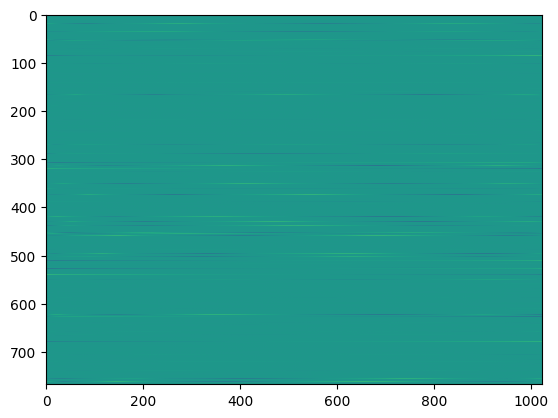

In [154]:
plt.imshow(wpe, interpolation="nearest", aspect="auto")

In [155]:
import matplotlib as mpl
import matplotlib.pyplot as plt


def display_image_in_actual_size(im_data):
    dpi = mpl.rcParams["figure.dpi"]
    height, width = im_data.shape

    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis("off")

    # Display the image.
    ax.imshow(im_data)

    plt.show()

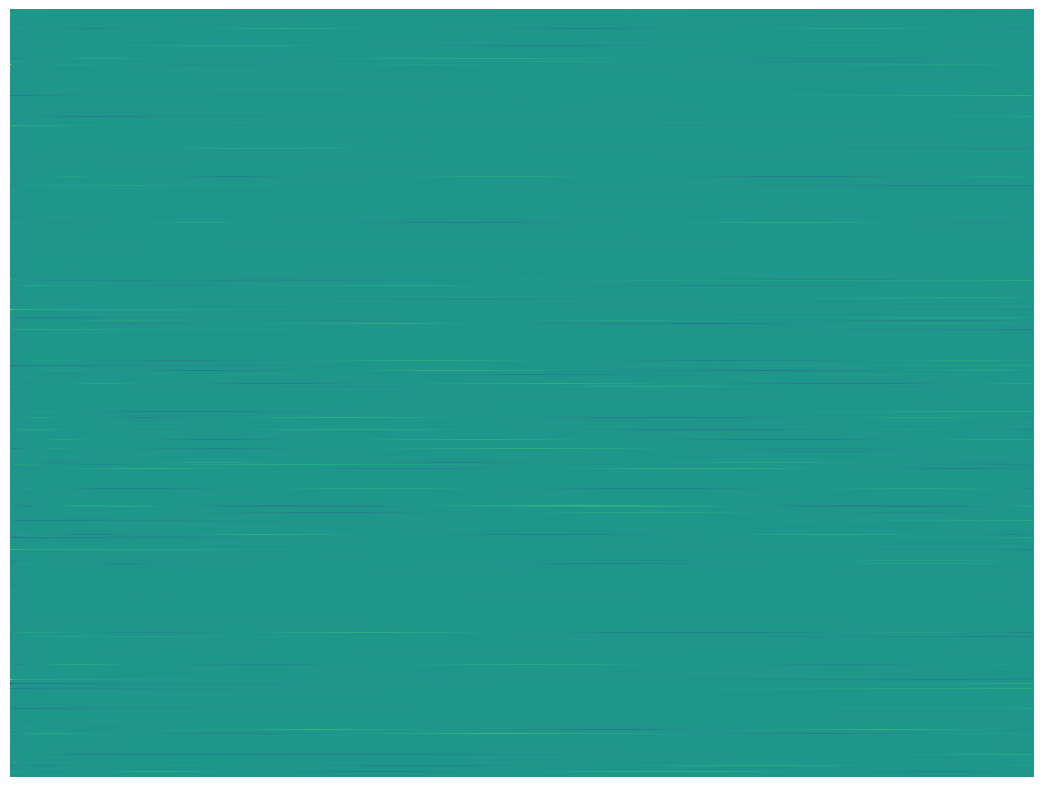

In [156]:
display_image_in_actual_size(wpe)